In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from experiment_train import *
from experiment_datasets import *
from helpers import *
import scipy.stats as st
import matplotlib
import pickle
import scipy
from scipy.optimize import curve_fit
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from model_conv import load_cat
import findiff

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2-dimensional image processed with 1-D convolutions

In [10]:
def gkern(kernlen = 20, nsig = 3, normalize = 'max'):
    """Returns a 2D Gaussian kernel."""
    assert normalize in ['max', '?'], "Normalize: max -- make max value to 1, ? -- for size-dependent to normlize the integral"
    
    # https://stackoverflow.com/questions/29731726/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy

    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    
    # normalizing
    #kern1d = kern1d / np.max(kern1d)
    
    kern1d = kern1d / np.sum(kern1d)
    
    # difference kernel
    kern1d = kern1d - kern1d.sum() / kernlen
    
    return kern1d

In [11]:
sum(gkern(kernlen=200))

3.469446951953614e-18

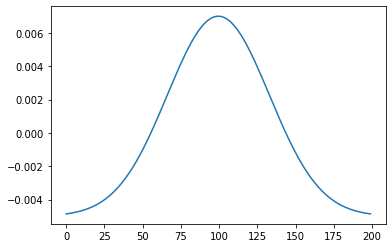

In [12]:
plt.plot(gkern(kernlen=200))

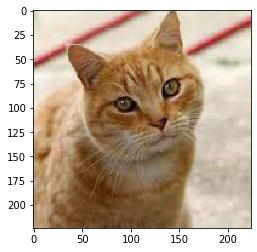

In [15]:
# W: out x in
W = np.random.randn(500, 10)
W = np.mean(load_cat(224).reshape(224, 224, 3), axis = 2)

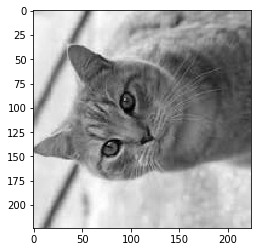

In [16]:
plt.imshow(W.T, cmap = 'gray')

In [17]:
sess = get_session()

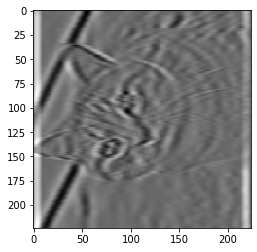

In [18]:
v = tf.reshape(tf.constant(W.T, dtype = tf.float32), (W.shape[1], 1, W.shape[0]))

#filt = tf.reshape(tf.constant([1.,-1]), (-1,1,1))
filt = tf.reshape(tf.constant(gkern(kernlen = 20), dtype = tf.float32), (-1,1,1))

plt.imshow(sess.run(
    tf.nn.convolution(v, filt,padding = 'SAME',
                      data_format = 'NCW')).reshape(W.shape[1], W.shape[0]),
          cmap = 'gray')

# Testing 1-dimensional data

In [19]:
def gkern(size = 20, nsig = 3, normalize = 'max'):
    """Returns a 2D Gaussian kernel."""
    
    assert normalize in ['max', '?'], "Normalize: max -- make max value to 1, ? -- for size-dependent to normlize the integral"
    
    if size == 2 and normalize == 'max':
        return [-1, 1]
    
    # https://stackoverflow.com/questions/29731726/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy

    x = np.linspace(-nsig, nsig, size+1)
    kern1d = np.diff(st.norm.cdf(x))
    
    # normalizing so that max == 1
    #kern1d = kern1d / np.max(kern1d)
    
    # normalizing over length
    kern1d = kern1d / kern1d.sum()
    
    # difference kernel -> integral is 0
    #kern1d = kern1d - kern1d.sum() / size
    
    #kern1d[size // 2] += 1
    
    return kern1d

f_dot 31.734482957381967
conv 0.4699103945075486


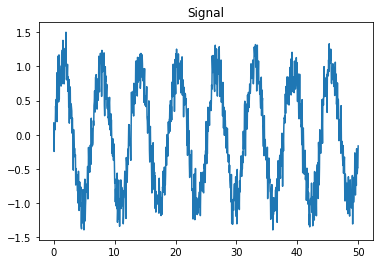

In [20]:
# length of xs
n = 1000

# xs for data
x = np.linspace(0, 50, n)

# data w/o noise
y = np.sin(x)


# scaling is not required as we have only one input neuron!
#y = y / len(x)

# printing scale-independent characteristics of y(x) -- test different n to check
print('f_dot', np.sum(np.abs(np.diff(y))))
print('conv', np.mean(np.abs(y - np.convolve(gkern(size = n // 5, nsig = 3), y, mode = 'same'))))

y = np.sin(x) + np.random.randn(len(x)) * 0.2

# signal
plt.title('Signal')
plt.plot(x, y)
plt.show()

In [21]:
# variable to fit
y_fit = tf.Variable([0.0] * len(x))

Instructions for updating:
Colocations handled automatically by placer.


In [22]:
def convolved(W, kernel):
    """ Input: W n_out x n_in, kernel: 1D array
        Output: operation of convolution of W along each n_in
        output shape: like W
    """
    
    # W as batch (n_in -- for each neuron x 1 channel x n_out -- to convolve)
    v = tf.reshape(tf.transpose(W), (W.shape[1], 1, W.shape[0]))

    # filter array: W, channels
    filt = tf.reshape(tf.constant(kernel, dtype = tf.float32), (-1, 1, 1))

    # returning reshaped convolution n_in x n_out
    z = tf.nn.convolution(v, filt,padding = 'SAME', data_format = 'NCW')
    z = tf.reshape(z, (W.shape[1], W.shape[0]))
    z = tf.transpose(z)
    return z

In [23]:
# kernel sizes for derivative
sizes = [0, 2, 5, 7]

# smoothness coefficients for convolution
conv_sizes = [n // 20, n // 10]

print(sizes, conv_sizes)

[0, 2, 5, 7] [50, 100]


In [24]:
# size: many output neurons, one input neuron -> conv
y_reshape_conv = tf.reshape(y_fit, (-1, 1))

In [25]:
def conv_loss(kernel, reduce = tf.reduce_sum, subtract = False, do_print = False):
    """ Loss for a kernel (smoothness) """
    if do_print:
        plt.plot(kernel)
        print('iCi', np.sum(np.multiply(kernel, np.arange(len(kernel)))))
        print('Ci', np.sum(kernel))
    z = convolved(y_reshape_conv, kernel)
    if subtract:
        z = z - y_reshape_conv
    z = tf.abs(z)
    z = reduce(z, axis = 0)
    z = tf.reduce_sum(z)
    return z

In [26]:
def derkern(size = 5):
    """ Difference kernel (derivative approximation )"""
    if size == 0:
        return [-1, 1]
    size = size * 2
    return findiff.coefficients(deriv = 1, acc = size)['center']['coefficients']

iCi 1
Ci 0
iCi 1.0000000000000002
Ci 4.163336342344337e-17
iCi 0.9999999999999771
Ci -5.894156690500196e-15
iCi 1.0000000000003917
Ci -2.9948862400458465e-14


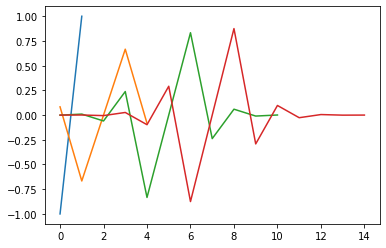

In [27]:
regs_derivative = {size: conv_loss(derkern(size = size), do_print = True) for size in sizes}

iCi 24.5
Ci 1.0
iCi 49.5
Ci 0.9999999999999998


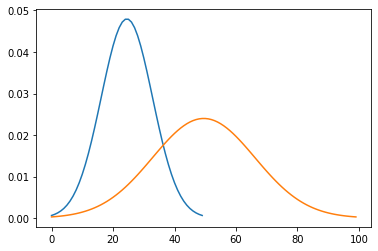

In [28]:
regs_smoothness = {size: conv_loss(gkern(size = size), do_print = True, subtract = True, reduce = tf.reduce_mean)
                   for size in conv_sizes}

In [29]:
loss_0 = tf.reduce_mean(tf.abs(y_fit - y))

In [30]:
def aggregate(dct):
    """ Aggregate dict of losses into one average loss """
    return sum(dct.values()) / len(dct)

In [31]:
def plot_coeff(coeff_derivative = 0.0003, coeff_smooth = 0.0001):
    global loss_0, regs_derivative, regs_smoothness
    print('Coeff derivative', coeff_derivative)
    print('Coeff smooth', coeff_smooth)
    
    loss = loss_0 + coeff_derivative * aggregate(regs_derivative) + coeff_smooth * aggregate(regs_smoothness)

    # optimizer
    op = tf.train.AdamOptimizer(learning_rate=0.005).minimize(loss)
    sess.run(tf.global_variables_initializer())

    def summary(name):
        print('%s Loss0, loss, regs' % name, sess.run([loss_0, loss, regs_derivative,
                                                      regs_smoothness]))
        
    summary('Before')

    for _ in range(500):
        sess.run(op)

    summary('After')

    y_fit_out = sess.run(y_fit)

    plt.figure(figsize=(15,4))
    plt.scatter(x, y_fit_out)
    plt.plot(x, y_fit_out, label = 'fit')
    plt.plot(x, y, label = 'true')
    plt.ylim((min(y), max(y)))
    plt.legend()

In [32]:
w1 = widgets.FloatLogSlider(value=0.01,min=-3,max=-1,step=0.1)
w2 = widgets.FloatLogSlider(value=0.3,min=-2,max=1,step=0.1)

interact(plot_coeff, coeff_derivative = w1, coeff_smooth = w2)

interactive(children=(FloatLogSlider(value=0.01, description='coeff_derivative', max=-1.0, min=-3.0), FloatLog…

<function __main__.plot_coeff(coeff_derivative=0.0003, coeff_smooth=0.0001)>

In [33]:
# NEW scaling with w staying
# n = 100 x = 50 der ~ 30 (like original) conv ~ 0.5 (like it should be)
# n = 1000 x = 50 der ~ 30 (like original) conv ~ 0.5 (like it should be)
# conv~50, even with rescaling of Gauss -- bad with SUM, need AVG

# OLD
# new with subtraction
# n=100 x = 50 der ~ 0.3 conv ~ 0.5
# n=1000 x = 50 der ~ 0.05 conv ~ 0.5
# why is derivative bad now?
# n=500 x = 100 der ~ 0.1 conv ~ 0.5

# old (with zero integral)
# scale n=50 deriv ~ 0.1, smooth ~ -5..-3
# scale n=500 deriv ~ 0.1..0.03, smooth ~ -4..-5
# looks like now it's scale-invariant! can deploy.

1. Just derivative -- why such weird results??? Why go down if can go up and save in both objectives?
Answer: too big learning rate

# Writing everything as a method

In [34]:
def smoothness_scale_free(W, coeff_derivative = 0.1, coeff_smoothness = 0.1):
    """ Input: matrix W: n_out x n_in
         Assume that W ~ 1/n_in
         Will return a tensor computing smoothness of W in n_out
    """
    
    # sizes
    n_out, n_in = map(lambda x : x.value, W.shape)
    
    # kernel sizes for derivative part
    sizes = [0, 2, 5, 7]

    # smoothness coefficients for convolution part
    conv_sizes = [n_out // 20, n_out // 10]
    
    # derivatives: calculate the derivative in the array
    regs_derivative = {size: conv_loss(derkern(size = size)) for size in sizes}
    
    # convolution to obtain the mean - original -> non-smoothness
    regs_smoothness = {size: conv_loss(gkern(size = size), subtract = True, reduce = tf.reduce_mean)
                   for size in conv_sizes}
    
    return coeff_derivative * aggregate(regs_derivative) + coeff_smoothness * aggregate(regs_smoothness)

In [35]:
smoothness_scale_free(y_reshape_conv)

<tf.Tensor 'add_14:0' shape=() dtype=float32>

In [36]:
def plot_coeff(coeff_derivative = 0.0003, coeff_smooth = 0.0001):
    global loss_0
    print('Coeff derivative', coeff_derivative)
    print('Coeff smooth', coeff_smooth)
    
    loss = loss_0 + smoothness_scale_free(y_reshape_conv, coeff_derivative = coeff_derivative,
                                         coeff_smoothness = coeff_smooth)

    # optimizer
    sess = get_session()
    op = tf.train.AdamOptimizer(learning_rate=0.005).minimize(loss)
    sess.run(tf.global_variables_initializer())

    def summary(name):
        pass
        #print('%s Loss0, loss, regs' % name, sess.run([loss_0, loss, regs_derivative,
            #                                          regs_smoothness]))
        
    summary('Before')

    for _ in range(500):
        sess.run(op)

    summary('After')

    y_fit_out = sess.run(y_fit)

    plt.figure(figsize=(15,4))
    plt.scatter(x, y_fit_out)
    plt.plot(x, y_fit_out, label = 'fit')
    plt.plot(x, y, label = 'true')
    plt.ylim((min(y), max(y)))
    plt.legend()

In [37]:
w1 = widgets.FloatLogSlider(value=0.01,min=-3,max=-1,step=0.1)
w2 = widgets.FloatLogSlider(value=0.3,min=-2,max=1,step=0.1)

interact(plot_coeff, coeff_derivative = w1, coeff_smooth = w2)

interactive(children=(FloatLogSlider(value=0.01, description='coeff_derivative', max=-1.0, min=-3.0), FloatLog…

<function __main__.plot_coeff(coeff_derivative=0.0003, coeff_smooth=0.0001)>

### Exporting code to `continuity.py`